In [1]:
import os
#import cv2
import numpy as np
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from tensorflow.keras import models
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix ,plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = (train_images - 127.5) / 127.5
test_images = test_images.astype('float32')/255.


train_images.shape

(60000, 28, 28)

This function below is just to display the generated images at the end of my training. Though my training didn't go as well as I thought it would I wanted to display my results as per the instructions.

In [3]:

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

The generator is a simple shape. It follows the instructions taking in 100 point which feed directly into a dense layer. The following dense layers are 324,576, and 784. I choose these number arbitrarily and they are just a slow accent to the final shap of 784 to make $28 \times 28$.

In [4]:
generator = keras.Sequential(
    [
        keras.Input(shape=(100)),
        layers.Dense(100),
         layers.BatchNormalization(),
         layers.LeakyReLU(),
         layers.Dense(324),
         layers.BatchNormalization(),
         layers.LeakyReLU(),


         layers.Dense(324),
         layers.BatchNormalization(),
         layers.LeakyReLU(),

         layers.Dense(576),
         layers.BatchNormalization(),
         layers.LeakyReLU(),

         layers.Dense(784),
         layers.BatchNormalization(),
         layers.LeakyReLU(),
         layers.Reshape((28,28,1)),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 324)               32724     
_________________________________________________________________
batch_normalization_1 (Batch (None, 324)               1296      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 324)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 324)               10

The discriminator is the opposite of the generator. It takes in $28 \times 28$ and flattens that to 784. The layers increase at the same rate and eventually turn into one activagtion node. I experimented with dropout and a few other things, but what I was doing didn't seem to work.

In [5]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Flatten(),
        layers.Dense(784),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        # layers.Dropout(0.3),

        layers.Dense(576),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(324),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(100),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(1)
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               615440    
_________________________________________________________________
batch_normalization_5 (Batch (None, 784)               3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 576)               452160    
_________________________________________________________________
batch_normalization_6 (Batch (None, 576)               2304      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 576)             

I followed the training recommended. I built my GANS by adding my generator first and the discriminator second. I then compiled the discriminator and the GANS separately. Afterwars the discriminator was set to trainable false. I tried this before compilation, and that led to massive errors.

In [6]:

# connect them
GANS = keras.Sequential()
# add generator
GANS.add(generator)
# add the discriminator
GANS.add(discriminator)
# compile model
opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(loss= 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

GANS.compile(loss= 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
discriminator.trainable = False

# Generate MVN and Images from it

Below are my functions to make my batched data to feed into the generator. It returns the permutated trainging batches as well as the permuted labels.

In [7]:
def genMVD(batchSize):
    MVN = np.random.randn(1, 100)
    for i in range(batchSize-1):
        MVN = np.concatenate((MVN,np.random.randn(1,100)),axis=0)
    return MVN

In [8]:
def makeBatch(batch):
    fakeBatch = genMVD(batch)
    #print(fakeBatch.shape)
    fakeGenImg = generator.predict(fakeBatch)
    randReals = np.random.randint(train_images.shape[0], size=batch)
    realImg =  train_images[randReals]

    #print(realImg.shape,fakeGenImg.shape)
    realImg = realImg.reshape(batch, 28, 28,1)
    trainingBatch_images = np.concatenate((realImg,fakeGenImg),axis=0)
    #print(trainingBatch_images.shape)
    trainingBatch_labels =  np.append(np.ones(batch),np.zeros(batch))
    relist = np.random.permutation(2*batch)
    trainingBatch_images =  trainingBatch_images[relist,:,:]
    trainingBatch_labels = trainingBatch_labels[relist]
    return trainingBatch_images,trainingBatch_labels

# Train Disciminator

The algorithm below is what was described in the instructions. The discriminator is trained first from a generated batch of images. After training is complete the discriminator is set to trainable false and the generator is trained by training the entire GANS.


In [9]:
EPOCHS = 100

d_hist = []
g_hist = []
for j in tqdm(range(EPOCHS)):
    btch = 16
    discriminator.trainable = True
    #for i in tqdm(range(10),desc= "Disc"):
    for i in range(10):
        batchsize = btch
        trainBImgs, trainBLabs = makeBatch(batchsize)
        history = discriminator.fit(trainBImgs, trainBLabs,
                                    batch_size = batchsize,
                                    epochs = batchsize,
                                    verbose=0)
        d_hist.append(list(history.history['loss']))
    discriminator.trainable = False
    #for i in tqdm(range(10),desc = "Gen"):
    for i in range(10):
        batchsize = btch
        trainBImgs= genMVD(batchsize)
        history = GANS.fit(trainBImgs, np.ones(batchsize),
                                    batch_size = batchsize,
                                    epochs = batchsize,
                                    verbose=0)
        g_hist.append(list(history.history['loss']))

g_hist = [item for sublist in g_hist for item in sublist]
d_hist = [item for sublist in d_hist for item in sublist]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:02<00:00,  7.23s/it]


Below is my loss Plot.though there's some oscillations, the trend is moving downward. And below that the images generated are starting to look like something. They're not great, but are starting to look like some kind of object.

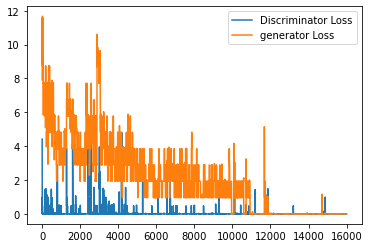

In [10]:
fig,ax = plt.subplots()
ax.plot(d_hist,label="Discriminator Loss")
ax.plot(g_hist,label="generator Loss")

plt.legend()
plt.show()


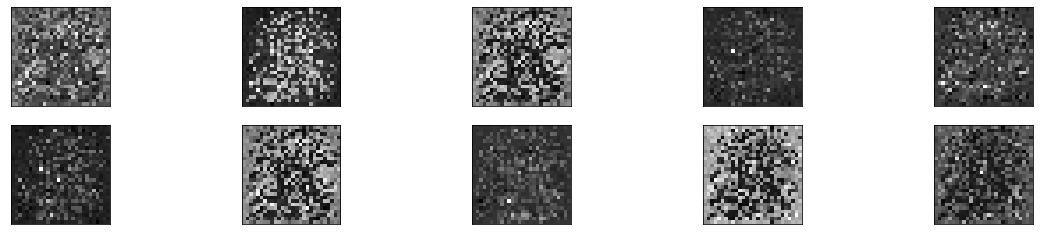

In [11]:
fakeBatch = genMVD(10)
#print(fakeBatch.shape)
pix = generator.predict(fakeBatch)
display(pix[:pix.shape[0]//2,:],pix[pix.shape[0]//2:,:])

# Next part:
   ## CNN GANS
   
   Next the CNN gans is made. I used a similar method to above, except that I used CNNs. The CNNs were just repeating 128. I wasn't quit sure what to make the size, so I stuck with this. This may or may not have been why my training didn't go well.

In [12]:
generator = keras.Sequential(
    [
        keras.Input(shape=(100)),
        layers.Dense((7*7*128)),
        layers.Reshape((7,7,128)),
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        #layers.Dropout(0.1),
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        #layers.Dropout(0.1),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
        #layers.Reshape((28,28)),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       409728    
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 128)       51

My discriminator below is just a mirror image of my generator. I again experimented with dropout, although I didn't notice great results.

In [13]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
	    layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 128)       3328      
_________________________________________________________________
batch_normalization_11 (Batc (None, 56, 56, 128)       512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 56, 56, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 112, 112, 128)     409728    
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 128)     512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 112, 112, 128)   

In [14]:

# connect them
GANS = keras.Sequential()
# add generator
GANS.add(generator)
# add the discriminator
GANS.add(discriminator)
# compile model
opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(loss= 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

GANS.compile(loss= 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
discriminator.trainable = False

# Train Disciminator

This is one to one the exact same training as before. I changed nothing in this sequence.

In [15]:
d_hist = []
g_hist = []
for j in tqdm(range(EPOCHS)):
    btch = 16
    discriminator.trainable = True
    #for i in tqdm(range(10),desc= "Disc"):
    for i in range(10):
        batchsize = btch
        trainBImgs, trainBLabs = makeBatch(batchsize)
        history = discriminator.fit(trainBImgs, trainBLabs,
                                    batch_size = batchsize,
                                    epochs = batchsize,
                                    verbose=0)
        d_hist.append(list(history.history['loss']))
    discriminator.trainable = False
    #for i in tqdm(range(10),desc = "Gen"):
    for i in range(10):
        batchsize = btch
        trainBImgs= genMVD(batchsize)
        history = GANS.fit(trainBImgs, np.ones(batchsize),
                                    batch_size = batchsize,
                                    epochs = batchsize,
                                    verbose=0)
        g_hist.append(list(history.history['loss']))

g_hist = [item for sublist in g_hist for item in sublist]
d_hist = [item for sublist in d_hist for item in sublist]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:07:55<00:00, 40.75s/it]


The Loss dropped much faster. There were few oscillations. It looks more like there were some kinds of random spikes, but as training went on, those began to decrease in size and frequency. And then below that are my final generated images. I don't know why they didn't come out right. I assume this is most likely from my architecture, but I wasn't sure what else to do.

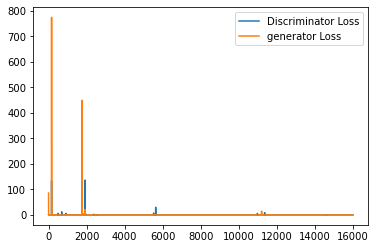

In [16]:
fig,ax = plt.subplots()
ax.plot(d_hist,label="Discriminator Loss")
ax.plot(g_hist,label="generator Loss")

plt.legend()
plt.show()

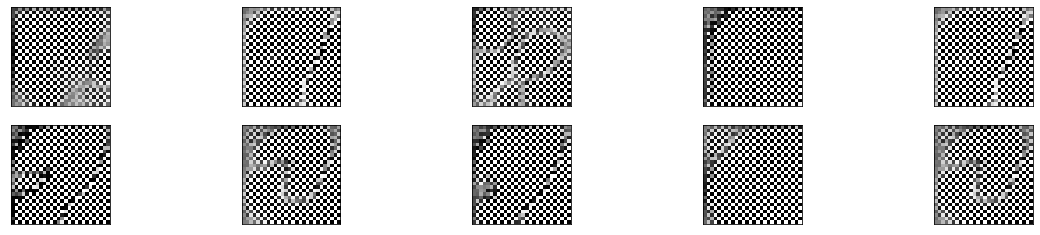

In [17]:
fakeBatch = genMVD(10)
#print(fakeBatch.shape)
pix = generator.predict(fakeBatch)
display(pix[:pix.shape[0]//2,:],pix[pix.shape[0]//2:,:])
